In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import pdb
from copy import deepcopy


In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
set_seed(0)

In [ ]:
class MLP(nn.Module):

    def __init__(self, num_classes, in_dim, context_dim, h, out_dim):
        super(MLP, self).__init__()
        # Add class conditioned lookup table
        self.embedding_table = nn.Embedding(num_classes + 1, in_dim + context_dim)
        # self.embedding_table = nn.Embedding(num_classes, in_dim + context_dim)
        self.embedding_table.weight.data.normal_(0, 1)
        # Create diffusion network
        self.network = nn.Sequential(nn.Linear(in_dim + context_dim, h), nn.Tanh(),
                                     nn.Linear(h, h), nn.Tanh(),
                                     nn.Linear(h, out_dim))

    def forward(self, x, context, target_class):
        class_embedding = self.embedding_table(target_class)
        x_t = torch.cat((x, context), dim=1)
        x_t_by_c = x_t + class_embedding
        return self.network(x_t_by_c)


class Dataset(torch.utils.data.Dataset):
    def __init__(self, dist1, dist2):
        self.dist1 = dist1
        self.dist2 = dist2
        assert self.dist1.shape == self.dist2.shape

    def __len__(self):
        return self.dist1.shape[0]

    def __getitem__(self, idx):
        return self.dist1[idx], self.dist2[idx]


def sample_multimodal_distribution(modes, std, batch_size=1000):
    dataset = []
    for i in range(batch_size):
        sample = np.random.randn(modes.shape[1]) * std
        mode_idx = np.random.randint(modes.shape[0])
        sample[0] += modes[mode_idx, 0]
        sample[1] += modes[mode_idx, 1]
        instance = np.concatenate((sample, np.array([mode_idx])))
        dataset.append(instance)
    return np.array(dataset, dtype="float32")


def train_rectified_flow(
    rectified_flow, optimizer, 
    train_dataloader, NB_EPOCHS, 
    eps=1e-15, contrastive_obj=False, 
    contrastive_lambda=0.05, null_dropout=0.1, 
    num_classes=2
):

    for epoch in tqdm(range(NB_EPOCHS)):
        for z0_, z1c in (train_dataloader):
            
            z0_, z1c = z0_.to(device), z1c.to(device)
            t = torch.rand((z1c.shape[0], 1), device=device)
            z0 = z0_[:, :2] # remove dummy class index
            z1 = z1c[:, :2] # remove class index
            z_t = t * z1 + (1.-t) * z0
            target = z1 - z0
            # Add null dropout
            labels = deepcopy(z1c[:, 2].long())
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < null_dropout
            labels = torch.where(drop_ids, num_classes, labels)
            
            pred = rectified_flow(z_t, t, target_class=labels)
            loss = (target - pred).view(pred.shape[0], -1).pow(2).sum(dim=1).mean()
            
            if contrastive_obj:
                negative_idx = torch.randperm(pred.shape[0])
                negatives = target[negative_idx]
                loss = loss - (negatives - pred).view(pred.shape[0], -1).pow(2).sum(dim=1).mean() * contrastive_lambda

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [5]:
device = 'cuda'
batch_size = 2048
dataset_size = 10_000
nb_epochs = 2_000
wd = 0.01

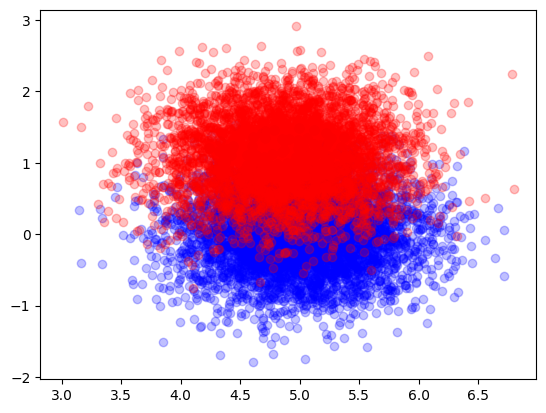

In [6]:
theta_1 = np.array([0, 4*np.pi]) / 360 * 2 * np.pi
std = 0.5
radius = 5.
modes = np.array([(radius * x, radius * y) for x, y in zip(np.cos(theta_1), np.sin(theta_1))])
pi_1 = sample_multimodal_distribution(modes, std, batch_size=dataset_size)
pi_1_0 = pi_1[pi_1[:, 2] == 0, :2]
pi_1_1 = pi_1[pi_1[:, 2] == 1, :2]

plt.scatter(pi_1_0[:, 0], pi_1_0[:, 1], color="blue", alpha=0.25, marker="o")
plt.scatter(pi_1_1[:, 0], pi_1_1[:, 1], color="red", alpha=0.25, marker="o")

In [7]:
theta_0 = np.array([180]) / 360 * 2 * np.pi
std = 0.5
radius = 15
modes = np.array([(radius * x, radius * y) for x, y in zip(np.cos(theta_0), np.sin(theta_0))])
pi_0 = sample_multimodal_distribution(modes, std, batch_size=dataset_size)

In [21]:
colors = [
    (250 / 255, 128 / 255, 114 / 255),
    (65 / 255, 105 / 255, 225 / 255)
]

plt.figure(figsize=(10, 4))

plt.scatter(pi_0[:, 0], pi_0[:, 1], color="mediumslateblue", alpha=0.25, marker="o")
plt.scatter(pi_1_0[:, 0], pi_1_0[:, 1], color=colors[0], alpha=0.25, marker="o")
plt.scatter(pi_1_1[:, 0], pi_1_1[:, 1], color=colors[1], alpha=0.25, marker="o")

# remove ticks
plt.xticks([])
plt.yticks([])
plt.axis('off')
# plt.show()
plt.savefig("/weka/prior-default/georges/research/REPA/notebooks/multimodal_data.png", bbox_inches='tight', dpi=600)
plt.close()

In [22]:
dataset = Dataset(pi_0, pi_1)

In [23]:
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [24]:
fm_model = MLP(num_classes=2, in_dim=2, context_dim=1, h=64, out_dim=2).to(device)
optimizer = torch.optim.Adam(fm_model.parameters(), lr=5e-3, weight_decay=wd)

In [25]:
fm_loss = train_rectified_flow(fm_model, optimizer, train_dataloader, nb_epochs, eps=1e-15)

100%|██████████| 2000/2000 [02:06<00:00, 15.86it/s]


In [35]:
def sample(rectified_flow, T, pi_0):
    samples = [pi_0.clone().unsqueeze(0)]
    for i in (range(T)):
        t = torch.ones((pi_0.shape[0], 1), device=samples[-1].device) * i / T
        inp = samples[-1].squeeze(0)
        drift_pred = rectified_flow(inp[:, :2], t, inp[:, 2].long())
        next_sample = deepcopy(samples[-1].detach())
        next_sample[0, :, :2] = next_sample[0, :, :2] + drift_pred * 1. / T
        # samples.append((samples[-1] + drift_pred * 1. / T))
        samples += [next_sample]
    return torch.cat(samples)

In [27]:
# print(test_pi_1.shape)
# print((test_pi_1[...,2] == 0).shape)

In [19]:
# test_pi_1.shape

In [28]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# for i in range(2):
#     ax[i].scatter(pi_1_0[:, 0], pi_1_0[:, 1], color="cyan", alpha=0.25, label="Class A True Distribution")
#     ax[i].scatter(pi_1_1[:, 0], pi_1_1[:, 1], color="salmon", alpha=0.25, label="Class B True Distribution")
# theta_1 = np.array([0, 5.5*np.pi]) / 360 * 2 * np.pi
# theta_0 = np.array([180]) / 360 * 2 * np.pi
# std = 0.5
# radius = 20

modes = np.array([(radius * x, radius * y) for x, y in zip(np.cos(theta_0), np.sin(theta_0))])
test_pi_0 = sample_multimodal_distribution(modes, 0.5, batch_size=2000)
test_pi_0[:, 2] = torch.randint(0, 2, (test_pi_0.shape[0],))
test_pi_1 = sample(fm_model, 1000, torch.from_numpy(test_pi_0).to(device))

test_pi_1_flat = test_pi_1.reshape(-1, 3)
test_pi_1_0 = test_pi_1_flat[test_pi_1_flat[:, 2] == 0, :2].reshape(1001, -1, 2)
test_pi_1_1 = test_pi_1_flat[test_pi_1_flat[:, 2] == 1, :2].reshape(1001, -1, 2)


# fig, ax = plt.subplots(1, 2, figsize=(15, 6))
# for i in range(2):
#     ax[i].scatter(pi_1_0[:, 0], pi_1_0[:, 1], color="cyan", alpha=0.25, label="Class A True Distribution")
#     ax[i].scatter(pi_1_1[:, 0], pi_1_1[:, 1], color="salmon", alpha=0.25, label="Class B True Distribution")
# ax[0].scatter(test_pi_1_0[-1, :, 0].data.cpu().numpy(), test_pi_1_0[-1, :, 1].data.cpu().numpy(), color="darkblue", alpha=0.25, label="Class A Generations")
# ax[1].scatter(test_pi_1_1[-1, :, 0].data.cpu().numpy(), test_pi_1_1[-1, :, 1].data.cpu().numpy(), color="maroon", alpha=0.25, label="Class B Generations")
# for i in range(2):
#     ax[i].legend()
#     ax[i].get_xaxis().set_visible(False)
#     ax[i].axes.get_yaxis().set_visible(False)
# plt.show()


In [29]:
# test_pi_1_1[:, sample, 0].cpu().detach().numpy().shape
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Compute KDE for density estimation
def compute_kde_density(x, y):
    values = np.vstack([x, y])
    kde = gaussian_kde(values)(values)
    return kde

def compute_vertical_kde_density(y):
    kde = gaussian_kde(y)(y)  # Only using y-values for KDE
    return kde

def compute_y_kde(y_values, y_grid):
    kde = gaussian_kde(y_values, bw_method="scott")  # Estimate density along y
    return kde(y_grid)

In [30]:
x_1_0, y_1_0 = test_pi_1_0[-1, :, 0].cpu().detach().numpy(), test_pi_1_0[-1, :, 1].cpu().detach().numpy()
x_1_1, y_1_1 = test_pi_1_1[-1, :, 0].cpu().detach().numpy(), test_pi_1_1[-1, :, 1].cpu().detach().numpy()
# density_1_0 = compute_kde_density(x_1_0, y_1_0)
# density_1_1 = compute_kde_density(x_1_1, y_1_1)
# density = compute_kde_density(y_1_0, y_1_1)

y_min = min(y_1_0.min(), y_1_1.min())
y_max = max(y_1_0.max(), y_1_1.max())
y_grid = np.linspace(y_min, y_max, 500)

density_1_0 = compute_y_kde(y_1_0, y_1_0)
density_1_1 = compute_y_kde(y_1_1, y_1_0)

In [72]:
print(density_1_1.max(), density_1_0.max())
print(density_1_1.min(), density_1_0.min())

0.711560476601154 0.72640893508872
1.0190141468997709e-06 0.0032193889672648577


In [31]:
# # make figure size
plt.figure(figsize=(10, 4))

for sample in range(0, test_pi_1_1.shape[1], 10):
    x = test_pi_1_1[:, sample, 0].cpu().detach().numpy()
    y = test_pi_1_1[:, sample, 1].cpu().detach().numpy()
    plt.plot(x, y, c='cornflowerblue', linewidth=2., alpha=0.5, zorder=1)
for sample in range(0, test_pi_1_0.shape[1], 10):
    plt.plot(
        test_pi_1_0[:, sample, 0].cpu().detach().numpy(),
        test_pi_1_0[:, sample, 1].cpu().detach().numpy(),
        c='lightsalmon', linewidth=2., alpha=0.5, zorder=1
    )


colors = [
    (250 / 255, 128 / 255, 114 / 255),
    (65 / 255, 105 / 255, 225 / 255)
]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=2000)
# norm = plt.Normalize(
#     test_pi_1_1[-1, :, 1].cpu().detach().numpy().min(),
#     test_pi_1_0[-1, :, 1].cpu().detach().numpy().max(), 
# )
norm = Normalize(
    vmin=min(density_1_0.min(), density_1_1.min()) + .5, 
    vmax=max(density_1_0.max(), density_1_1.max()) + .5
)

plt.scatter(test_pi_0[:, 0], test_pi_0[:, 1], color="mediumslateblue", alpha=1.0, s=6, zorder=2)
plt.scatter(
    test_pi_1_0[-1, :, 0].data.cpu().numpy(), 
    test_pi_1_0[-1, :, 1].data.cpu().numpy(), 
    # c="salmon", 
    alpha=1.0, s=6, zorder=2,
    c=test_pi_1_0[-1, :, 1].data.cpu().numpy(),
    cmap=custom_cmap, norm=norm
)
plt.scatter(
    test_pi_1_1[-1, :, 0].data.cpu().numpy(), 
    test_pi_1_1[-1, :, 1].data.cpu().numpy(), 
    # c="royalblue",
    alpha=1.0, s=6, zorder=2,
    c=test_pi_1_1[-1, :, 1].data.cpu().numpy(),
    cmap=custom_cmap, norm=norm
)
# remove ticks
plt.xticks([])
plt.yticks([])
plt.axis('off')
# plt.show()
plt.savefig("/weka/prior-default/georges/research/REPA/notebooks/fm_highres.png", bbox_inches='tight', dpi=600)
plt.close()


In [85]:
def cfg_sample(rectified_flow, T, pi_0, cfg_scale=1.0):
    samples = [pi_0.clone().unsqueeze(0)]
    for i in (range(T)):
        t = torch.ones((pi_0.shape[0], 1), device=samples[-1].device) * i / T
        inp = samples[-1].squeeze(0)
        drift_pred = rectified_flow(inp[:, :2], t, inp[:, 2].long())
        uncond_drif_pred = rectified_flow(inp[:, :2], t, torch.ones((inp.shape[0]), device=inp.device, dtype=torch.long) * 2)
        next_sample = deepcopy(samples[-1].detach())
        drift_step = uncond_drif_pred + cfg_scale * (drift_pred - uncond_drif_pred)
        next_sample[0, :, :2] = next_sample[0, :, :2] + drift_step * 1. / T
        # samples.append((samples[-1] + drift_pred * 1. / T))
        samples += [next_sample]
    return torch.cat(samples)

In [94]:
cfg_test_pi_1 = cfg_sample(fm_model, 1000, torch.from_numpy(test_pi_0).to(device), cfg_scale=2.5)

cfg_test_pi_1_flat = cfg_test_pi_1.reshape(-1, 3)
cfg_test_pi_1_0 = cfg_test_pi_1_flat[cfg_test_pi_1_flat[:, 2] == 0, :2].reshape(1001, -1, 2)
cfg_test_pi_1_1 = cfg_test_pi_1_flat[cfg_test_pi_1_flat[:, 2] == 1, :2].reshape(1001, -1, 2)

In [95]:
cfg_test_pi_1.shape, cfg_test_pi_1_flat.shape, cfg_test_pi_1_0.shape

(torch.Size([1001, 2000, 3]),
 torch.Size([2002000, 3]),
 torch.Size([1001, 1002, 2]))

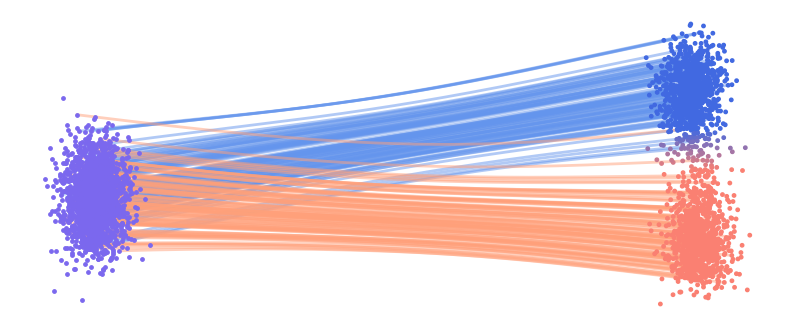

In [96]:
# make figure size
# plt.figure(figsize=(20, 15))
# plt.scatter(test_pi_0[:, 0], test_pi_0[:, 1], color="purple", alpha=0.25)
# plt.scatter(cfg_test_pi_1_0[-1, :, 0].data.cpu().numpy(), test_pi_1_0[-1, :, 1].data.cpu().numpy(), c="red", alpha=0.25)
# plt.scatter(cfg_test_pi_1_1[-1, :, 0].data.cpu().numpy(), test_pi_1_1[-1, :, 1].data.cpu().numpy(), c="blue", alpha=0.25)

# for i in tqdm(range(1, 1000, 1)):
#     for j in range(0, cfg_test_pi_1_0.shape[1], 10):
#         plt.plot([cfg_test_pi_1_0[i-1, j, 0].item(), cfg_test_pi_1_0[i, j, 0].item()],
#                     [cfg_test_pi_1_0[i-1, j, 1].item(), cfg_test_pi_1_0[i, j, 1].item()],
#                     c="darkred", linewidth=.5)

# for i in tqdm(range(1, 1000, 1)):
#     for j in range(0, cfg_test_pi_1_1.shape[1], 10):
#         plt.plot([cfg_test_pi_1_1[i-1, j, 0].item(), cfg_test_pi_1_1[i, j, 0].item()],
#                     [cfg_test_pi_1_1[i-1, j, 1].item(), cfg_test_pi_1_1[i, j, 1].item()],
#                     c='deepskyblue', linewidth=.5)



# # make figure size
plt.figure(figsize=(10, 4))

for sample in range(0, cfg_test_pi_1_1.shape[1], 10):
    x = cfg_test_pi_1_1[:, sample, 0].cpu().detach().numpy()
    y = cfg_test_pi_1_1[:, sample, 1].cpu().detach().numpy()
    plt.plot(x, y, c='cornflowerblue', linewidth=2., alpha=0.5, zorder=1)
for sample in range(0, cfg_test_pi_1_0.shape[1], 10):
    plt.plot(
        cfg_test_pi_1_0[:, sample, 0].cpu().detach().numpy(),
        cfg_test_pi_1_0[:, sample, 1].cpu().detach().numpy(),
        c='lightsalmon', linewidth=2., alpha=0.5, zorder=1
    )


colors = [
    (250 / 255, 128 / 255, 114 / 255),
    (65 / 255, 105 / 255, 225 / 255)
]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=2000)
norm = Normalize(
    vmin=min(density_1_0.min(), density_1_1.min()) + .5, 
    vmax=max(density_1_0.max(), density_1_1.max()) + .5
)

plt.scatter(test_pi_0[:, 0], test_pi_0[:, 1], color="mediumslateblue", alpha=1.0, s=6, zorder=2)
plt.scatter(
    cfg_test_pi_1_0[-1, :, 0].data.cpu().numpy(), 
    cfg_test_pi_1_0[-1, :, 1].data.cpu().numpy(), 
    # c="salmon", 
    alpha=1.0, s=6, zorder=2,
    c=cfg_test_pi_1_0[-1, :, 1].data.cpu().numpy(),
    cmap=custom_cmap, norm=norm
)
plt.scatter(
    cfg_test_pi_1_1[-1, :, 0].data.cpu().numpy(), 
    cfg_test_pi_1_1[-1, :, 1].data.cpu().numpy(), 
    # c="royalblue",
    alpha=1.0, s=6, zorder=2,
    c=cfg_test_pi_1_1[-1, :, 1].data.cpu().numpy(),
    cmap=custom_cmap, norm=norm
)
# remove ticks
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()




In [32]:
cf_model = MLP(num_classes=2, in_dim=2, context_dim=1, h=64, out_dim=2).to(device)
optimizer = torch.optim.Adam(cf_model.parameters(), lr=5e-3, weight_decay=wd)
cf_loss = train_rectified_flow(cf_model, optimizer, train_dataloader, nb_epochs, eps=1e-15, contrastive_obj=True, contrastive_lambda=0.5)

100%|██████████| 2000/2000 [02:19<00:00, 14.34it/s]


In [33]:
torch.from_numpy(test_pi_0).to(device)

tensor([[-14.9144,   0.8464,   0.0000],
        [-14.0289,  -0.3068,   0.0000],
        [-14.3144,  -0.3235,   1.0000],
        ...,
        [-13.6671,   0.4072,   0.0000],
        [-14.5371,   1.0867,   1.0000],
        [-14.7001,  -0.0718,   0.0000]], device='cuda:0')

In [36]:
cf_test_pi_1 = sample(cf_model, 1000, torch.from_numpy(test_pi_0).to(device))

cf_test_pi_1_flat = cf_test_pi_1.reshape(-1, 3)
cf_test_pi_1_0 = cf_test_pi_1_flat[cf_test_pi_1_flat[:, 2] == 0, :2].reshape(1001, -1, 2)
cf_test_pi_1_1 = cf_test_pi_1_flat[cf_test_pi_1_flat[:, 2] == 1, :2].reshape(1001, -1, 2)

In [37]:
# plt.figure(figsize=(20, 15))
# plt.scatter(test_pi_0[:, 0], test_pi_0[:, 1], color="purple", alpha=0.25)
# plt.scatter(cf_test_pi_1_0[-1, :, 0].data.cpu().numpy(), cf_test_pi_1_0[-1, :, 1].data.cpu().numpy(), c="red", alpha=0.25)
# plt.scatter(cf_test_pi_1_1[-1, :, 0].data.cpu().numpy(), cf_test_pi_1_1[-1, :, 1].data.cpu().numpy(), c="blue", alpha=0.25)

# for i in tqdm(range(1, 1000, 1)):
#     for j in range(0, cf_test_pi_1_0.shape[1], 10):
#         plt.plot([cf_test_pi_1_0[i-1, j, 0].item(), cf_test_pi_1_0[i, j, 0].item()],
#                     [cf_test_pi_1_0[i-1, j, 1].item(), cf_test_pi_1_0[i, j, 1].item()],
#                     c="darkred", linewidth=.5)

# for i in tqdm(range(1, 1000, 1)):
#     for j in range(0, cf_test_pi_1_1.shape[1], 10):
#         plt.plot([cf_test_pi_1_1[i-1, j, 0].item(), cf_test_pi_1_1[i, j, 0].item()],
#                     [cf_test_pi_1_1[i-1, j, 1].item(), cf_test_pi_1_1[i, j, 1].item()],
#                     c='deepskyblue', linewidth=.5)



# make figure size
# plt.figure(figsize=(20, 15))
# plt.scatter(test_pi_0[:, 0], test_pi_0[:, 1], color="purple", alpha=0.25)
# plt.scatter(cfg_test_pi_1_0[-1, :, 0].data.cpu().numpy(), test_pi_1_0[-1, :, 1].data.cpu().numpy(), c="red", alpha=0.25)
# plt.scatter(cfg_test_pi_1_1[-1, :, 0].data.cpu().numpy(), test_pi_1_1[-1, :, 1].data.cpu().numpy(), c="blue", alpha=0.25)

# for i in tqdm(range(1, 1000, 1)):
#     for j in range(0, cfg_test_pi_1_0.shape[1], 10):
#         plt.plot([cfg_test_pi_1_0[i-1, j, 0].item(), cfg_test_pi_1_0[i, j, 0].item()],
#                     [cfg_test_pi_1_0[i-1, j, 1].item(), cfg_test_pi_1_0[i, j, 1].item()],
#                     c="darkred", linewidth=.5)

# for i in tqdm(range(1, 1000, 1)):
#     for j in range(0, cfg_test_pi_1_1.shape[1], 10):
#         plt.plot([cfg_test_pi_1_1[i-1, j, 0].item(), cfg_test_pi_1_1[i, j, 0].item()],
#                     [cfg_test_pi_1_1[i-1, j, 1].item(), cfg_test_pi_1_1[i, j, 1].item()],
#                     c='deepskyblue', linewidth=.5)



# # make figure size
plt.figure(figsize=(10, 4))

for sample in range(0, cf_test_pi_1_1.shape[1], 10):
    x = cf_test_pi_1_1[:, sample, 0].cpu().detach().numpy()
    y = cf_test_pi_1_1[:, sample, 1].cpu().detach().numpy()
    plt.plot(x, y, c='cornflowerblue', linewidth=2., alpha=0.5, zorder=1)
for sample in range(0, cf_test_pi_1_0.shape[1], 10):
    plt.plot(
        cf_test_pi_1_0[:, sample, 0].cpu().detach().numpy(),
        cf_test_pi_1_0[:, sample, 1].cpu().detach().numpy(),
        c='lightsalmon', linewidth=2., alpha=0.5, zorder=1
    )


colors = [
    (250 / 255, 128 / 255, 114 / 255),
    (65 / 255, 105 / 255, 225 / 255)
]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=2000)
norm = Normalize(
    vmin=min(density_1_0.min(), density_1_1.min()) + .5, 
    vmax=max(density_1_0.max(), density_1_1.max()) + .5
)

plt.scatter(test_pi_0[:, 0], test_pi_0[:, 1], color="mediumslateblue", alpha=1.0, s=6, zorder=2)
plt.scatter(
    cf_test_pi_1_0[-1, :, 0].data.cpu().numpy(), 
    cf_test_pi_1_0[-1, :, 1].data.cpu().numpy(), 
    # c="salmon", 
    alpha=1.0, s=6, zorder=2,
    c=cf_test_pi_1_0[-1, :, 1].data.cpu().numpy(),
    cmap=custom_cmap, norm=norm
)
plt.scatter(
    cf_test_pi_1_1[-1, :, 0].data.cpu().numpy(), 
    cf_test_pi_1_1[-1, :, 1].data.cpu().numpy(), 
    # c="royalblue",
    alpha=1.0, s=6, zorder=2,
    c=cf_test_pi_1_1[-1, :, 1].data.cpu().numpy(),
    cmap=custom_cmap, norm=norm
)
# remove ticks
plt.xticks([])
plt.yticks([])
plt.axis('off')
# plt.show()
plt.savefig("/weka/prior-default/georges/research/REPA/notebooks/cfm_highres.png", bbox_inches='tight', dpi=600)
plt.close()


In [ ]:
def train_ccrectified_flow(rectified_flow, optimizer, train_dataloader, NB_EPOCHS, eps=1e-15, contrastive_obj=False, contrastive_lambda=0.05):

    for epoch in tqdm(range(NB_EPOCHS)):
        for z0_, z1c in (train_dataloader):

            z0_, z1c = z0_.to(device), z1c.to(device)
            t = torch.rand((z1c.shape[0], 1), device=device)
            z0 = z0_[:, :2] # remove dummy class index
            z1 = z1c[:, :2] # remove class index
            z_t = t * z1 + (1.-t) * z0
            target = z1 - z0

            pred = rectified_flow(z_t, t, target_class=z1c[:, 2].long())
            loss = (target - pred).view(pred.shape[0], -1).pow(2).sum(dim=1).mean()
            
            if contrastive_obj:
                classes = z1c[:, 2].long()
                negative_idx = torch.randperm(pred.shape[0])
                negatives = target[negative_idx]
                loss = loss - (negatives - pred).view(pred.shape[0], -1).pow(2).sum(dim=1).mean() * contrastive_lambda

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [ ]:
# visualize_model_generations(cf_model)

In [ ]:
cf_model_p9 = MLP(num_classes=2, in_dim=2, context_dim=1, h=64, out_dim=2).to(device)
optimizer = torch.optim.Adam(cf_model_p9.parameters(), lr=5e-3, weight_decay=wd)
cf_loss_p9 = train_rectified_flow(cf_model_p9, optimizer, train_dataloader, 2000, eps=1e-15, contrastive_obj=True, contrastive_lambda=0.9)

100%|██████████| 2000/2000 [02:26<00:00, 13.63it/s]


In [ ]:
visualize_model_generations(cf_model_p9)

In [51]:
cf_model = MLP(num_classes=2, in_dim=2, context_dim=1, h=64, out_dim=2).to(device)
optimizer = torch.optim.Adam(cf_model.parameters(), lr=5e-3, weight_decay=wd)
cf_loss = train_rectified_flow(cf_model, optimizer, train_dataloader, 500, eps=1e-15, contrastive_obj=True, contrastive_lambda=10.0)

100%|██████████| 500/500 [00:34<00:00, 14.64it/s]


In [ ]:
visualize_model_generations(cf_model)

In [1]:
! pip install einops

In [28]:
from einops import repeat, rearrange
import torch

bsz = 10
choices = repeat(torch.arange(bsz), "b -> B b", B=bsz).clone()
choices[torch.eye(bsz).bool()] = -1
choices = rearrange(choices[choices != -1], "(b c) -> b c", b=bsz, c=bsz-1)


choices = choices[torch.arange(bsz),torch.randint(0, bsz-1, (bsz,))]

# choices = choices[:, torch.randperm(choices.shape[1])]

In [29]:
choices

tensor([7, 0, 9, 2, 2, 0, 7, 5, 2, 6])

In [14]:
choices

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])